# LSI and Scikit-Learn
    <Name>
    <Class>
    <Date>

In [2]:
import os
import string
import numpy as np
import sklearn
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

In [3]:
def prob1():
    """Recreate the plot in Figure 1 by performing PCA on the breast 
    cancer dataset. Translate the columns of X to have mean 0.
    Include the amount of variance captured by the first two principal 
    components in the graph title."""
    
    # Load in data
    cancer = sklearn.datasets.load_breast_cancer()
    X = cancer.data
    y = cancer.target # Class labels (0 or 1)
    
    # Rescale data
    Y = X - np.mean(X, axis = 0)
    
    # Perform the full SVD
    U, sigma, Vt = np.linalg.svd(Y, full_matrices= True)
    
    # Get the two components
    PCA_1 = Y @ Vt.T[:, 0]
    PCA_2 = Y @ Vt.T[:,1]
    
    # Plot data
    plt.scatter(PCA_1[y==0], PCA_2[y==0], c = 'blue', label = 'Malignant')
    plt.scatter(PCA_1[y==1], PCA_2[y==1], c = 'red', label = 'Benign')
    plt.legend()
    plt.xlabel('First Principal Component')
    plt.xlim(-4000, 1000)
    plt.ylabel('Second Principal Component')
    plt.ylim(-600, 800)
    plt.title('Breast Cancer Principal Component Analysis')
    plt.show()
    
    # Calculate the variance captured by the first two principal components
    print("Variance captured by the first two principal components: \n")
    print(sum(sigma[:2]**2)/sum(sigma**2))
     
    
    
    
    

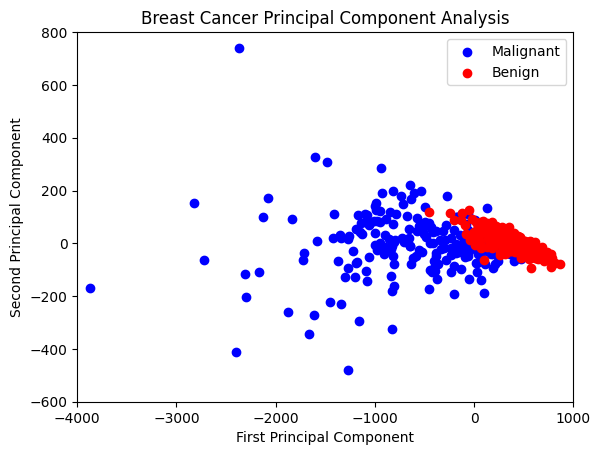

Variance captured by the first two principal components: 

0.9982211613741725


In [4]:
prob1()

## Problem 2
Implement the function similar()

In [5]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components 
    of a document and returns two indices: the index of the document 
    that is least similar and the index of the document that is most 
    similar to i.
    
    Parameters:
        i: index of a document
        Xhat: decomposed data
    
    Returns:
        index_min: index of the document least similar to document i
        index_max: index of the document most similar to document i
    """
    
    # Initialize norm dictionary
    norms = dict()
    
    # Find Document i
    Document_i = Xhat[i,:]
    
    # For all Document j's that are not Document i
    for j in range(Xhat.shape[0]):
        if j != i:
            Document_j = Xhat[j,:]
            
            # Find the norm and append it to the dictionary
            norm = np.dot(Document_i, Document_j)/(np.linalg.norm(Document_i)* np.linalg.norm(Document_j))
            norms[j] = norm    
            
    
    # Find index of the document least and most similar to document i      
    index_min = min(norms, key= norms.get)
    index_max = max(norms, key = norms.get)
    
    # Return indices
    return index_min,index_max
    
    

In [6]:
# Test case
X = np.array([
    [0.78, 0.14, 0.12, 0.  ],
    [0.64, 0.97, 0.  , 0.  ],
    [0.  , 0.  , 0.63, 0.46],
    [0.  , 0.84, 0.6 , 0.  ],
    [0.29, 0.89, 0.51, 0.  ],
    [0.77, 0.  , 0.27, 0.2 ],
    [0.86, 0.47, 0.  , 0.06],
    [0.89, 0.  , 0.  , 0.  ]
]) 
print(similar(4, X))

(7, 3)


### Function for Problem 3

In [7]:
def document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents.
    
    Returns:
        X ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = sorted([folder+p for p in os.listdir(folder) if p.endswith(".txt")])

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, storing counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)
              
    # Create sparse matrix holding these word counts.
    X = sparse.csr_array((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [17]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 
    principal components to find the most similar and least similar 
    speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """  
    
    # Load in matrix and paths  
    document_matrix, paths = document_converter()
   
    # Get index of speech
    speech_index = paths.index(speech)
    
    # Perform the SVD to get the 7 largest singular values
    U, sigma, Vt = sparse.linalg.svds(document_matrix, k = l, random_state= 28)
    
    # Get new matrix
    new_X = document_matrix @ Vt.T[:, :l]
    
    # Get most similar speech and least similar speech
    min_index, max_index = similar(speech_index, new_X)
    min_path, max_path = paths[min_index ], paths[max_index]
    return(os.path.basename(max_path)[:-4], os.path.basename(min_path)[:-4])
    

In [18]:
# Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [10]:
def weighted_document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
        A ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    
    # Get matrix and paths
    X, paths = document_converter()

    # Initialize matrices 
    I, J = X.shape[0], X.shape[1]
    p = np.zeros((I,J))
    g = np.zeros(J)
    A = np.zeros((I,J))
    
    # Get p
    row_sums = np.sum(X, axis = 1)
    p = X / row_sums[:,np.newaxis]
    
    # Get g
    for j in range(J):
        g[j] += 1
        for i in range(I):
            g[j] += (p[i,j] * np.log1p(p[i,j]))/(np.log(I))
            
    # Make A
    A = g[j, np.newaxis] * np.log1p(X)
    return A, paths
            
    
        
        
    

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [11]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with 
    the first 7 principal components to find the most similar and least 
    similar speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """

    # Load in weighted matrix and paths
    doc_matrix, paths = weighted_document_converter()
    
    # Get index of speech
    speech_index = paths.index(speech)
    
    # Get new matrix
    trunc = TruncatedSVD(n_components = l, random_state = 74)
    Xhat = trunc.fit_transform(doc_matrix)
    
    # Find most similar and least similar speeches
    min_index, max_index = similar(speech_index, Xhat)
    min_path, max_path = paths[min_index], paths[max_index]
    return(os.path.basename(max_path)[:-4], os.path.basename(min_path)[:-4])

In [12]:
# Run this box after you have completed prob5()
speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

('1992-Bush', '1946-Truman')
('1985-Reagan', '1946-Truman')


## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [13]:
# Load in data
cancer = sklearn.datasets.load_breast_cancer()
X = cancer.data
y = cancer.target 

# Split into train-test data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Fit the estimator to training data and predict the test labels
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

# Compute the confusion matrix by comparing actual labels to
# predict labels

CM = confusion_matrix(y_test, knn_predicted)


# Get precision, recall, and F1 scores all at once.
# The row labeled 1 gives these scores as we normally calculate them.
print("KNeighbors Classifier: \n")
print(classification_report(y_test, knn_predicted))

KNeighbors Classifier: 

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        56
           1       0.92      0.92      0.92        87

    accuracy                           0.90       143
   macro avg       0.90      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143



In [14]:
# Fit the estimator to training data and predict the test labels
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)

# Get precision, recall, and F1 scores all at once.
# The row labeled 1 gives these scores as we normally calculate them.

print("Random Forest Classifier: \n")
print(classification_report(y_test, rfc_predicted))

Random Forest Classifier: 

              precision    recall  f1-score   support

           0       0.96      0.95      0.95        56
           1       0.97      0.98      0.97        87

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



The classifier that would be best for this would be the Random Forest Classifier. This is bcause the Preicison, Recall, and F1-score for the Random Forest Classifier are all higher than their respective counterparts in the KNeighbors Classifier.

## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [15]:
# Load in data
cancer = sklearn.datasets.load_breast_cancer()
X = cancer.data
y = cancer.target 

# Split in test-train data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Start a RandomForest classifier
rfc = RandomForestClassifier()

# Specify values for certain hyperparameters
param_grid = {"n_estimators": [100,200],
              "max_depth": [3,5,7],
              "min_samples_leaf": [1,2,5]}

# Create a GridSearch object
rfc_gs = GridSearchCV(rfc, param_grid, scoring = 'f1', n_jobs = -1)

# Run the actual search. This may take some time.
rfc_gs.fit(X_train, y_train)

# After fitting, you can access data about the results.
print("Results from Grid Search: \n")
print(rfc_gs.best_params_, rfc_gs.best_score_, sep = '\n')
print()

# Get predicted data
rfc_predicted = rfc_gs.predict(X_test)

# Compute the confusion matrix by comparing actual labels
# to predict labels

CM = confusion_matrix(y_test, rfc_predicted)
print("Confusion Matrix:")
print(CM)
print()

# Get precision, recall, and F1 scores all at once.
# The row labeled 1 gives these scores as we normally calculate them.

print("GridSearch Random Forest Classifier: \n")
print(classification_report(y_test, rfc_predicted))


Results from Grid Search: 

{'max_depth': 7, 'min_samples_leaf': 1, 'n_estimators': 200}
0.9701953767680085

Confusion Matrix:
[[52  3]
 [ 3 85]]

GridSearch Random Forest Classifier: 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        55
           1       0.97      0.97      0.97        88

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least 0.96

In [16]:
# Load in data
cancer = sklearn.datasets.load_breast_cancer()
X = cancer.data
y = cancer.target 

# Use the same train-test split as before
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Create the pipeline
pipe = Pipeline([("scaler", StandardScaler()),
                 ("pca", PCA()),
                 ("knn", KNeighborsClassifier())])

# Define the parameter grid
param_grid = {
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'pca__n_components': [1,2,3,4,5],
    'knn__n_neighbors': [3,5,7,9],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree']
}

# Fit using training data
pipe_gs = GridSearchCV(pipe, param_grid,
                       scoring = 'f1', n_jobs = -1).fit(X_train, y_train)

# Get the best hyperparameters
params = pipe_gs.best_params_

# Print out best parameters and best score. Attain a score of at least 0.96
print("Best Parameters: \n")
print(params)
print("")
print("Best Score: \n")
print(pipe_gs.best_score_)







Best Parameters: 

{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'pca__n_components': 5, 'scaler__with_mean': True, 'scaler__with_std': True}

Best Score: 

0.976042346353587
